## **Unsupervised Learning: Human Activity Recognition Analysis**

### **1. Project Overview**

**Description:**
The goal of this project is to analyze the **Human Activity Recognition (HAR)** dataset using unsupervised learning techniques. The dataset consists of sensor data (accelerometer and gyroscope) collected from smartphones carried by participants performing six different physical activities.

**Objectives:**
- Exploratory Data Analysis (EDA): Understand the data structure, class balance, and feature distributions.

- Dimensionality Reduction: Visualize the high-dimensional data (561 features) in 2D space using PCA and t-SNE.

- Clustering: Apply the K-Means algorithm to group activities without using label information.

- Evaluation: Assess the model's ability to distinguish between static and dynamic activities by comparing clusters with ground truth labels.

### **2. Imports**
Importing necessary libraries for data manipulation, visualization, and machine learning.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Dict, Tuple
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score

### **3. Data Load**

Loading the UCI HAR dataset. Since this is an unsupervised learning task, we will merge the training and testing sets to maximize the amount of data available for clustering.

- Input: Raw text files from the UCI dataset.

- Output: A combined feature matrix X and a label vector y (used only for validation).

Define the base folder path:

In [2]:
BASE_FOLDER = 'UCI HAR Dataset'

Helper function to load TXT files:

In [3]:
def load_file(sub_path):
    """Loads a whitespace-delimited TXT file."""
    filepath = os.path.join(BASE_FOLDER, sub_path)
    # Use delim_whitespace=True to read the raw data files
    return pd.read_csv(filepath, delim_whitespace=True, header=None)

print(f"Data will be loaded from: {BASE_FOLDER}")

Data will be loaded from: UCI HAR Dataset


Load raw data from train and test folders:

In [4]:
X_train = load_file(os.path.join('train', 'X_train.txt'))
y_train = load_file(os.path.join('train', 'y_train.txt'))
X_test = load_file(os.path.join('test', 'X_test.txt'))
y_test = load_file(os.path.join('test', 'y_test.txt'))

C:\Users\jakub\AppData\Local\Temp\ipykernel_18808\2046537255.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\jakub\AppData\Local\Temp\ipykernel_18808\2046537255.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\jakub\AppData\Local\Temp\ipykernel_18808\2046537255.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\jakub\AppData\Local\Temp\ipykernel_18808\2046537255.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a futur

Combine the feature sets (X) and label sets (y):

In [5]:
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

print(f"Combined samples loaded: {X.shape[0]}")

Combined samples loaded: 10299


Load the 561 feature names:

In [6]:
features_df = load_file('features.txt')
X.columns = features_df[1].values

C:\Users\jakub\AppData\Local\Temp\ipykernel_18808\2046537255.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None)


Flatten labels (y) and create the activity map:

In [7]:
y = y.values.flatten()
activity_labels_df = load_file('activity_labels.txt')
label_map = dict(zip(activity_labels_df[0], activity_labels_df[1]))

C:\Users\jakub\AppData\Local\Temp\ipykernel_18808\2046537255.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filepath, delim_whitespace=True, header=None)


Verification of data shapes:

In [8]:
print("\n--- Finalization ---")
print(f"Final shape of X: {X.shape}")
print("Sample 5 rows of X data:")
display(X.sample(5))
print("Data loading completed successfully.")


--- Finalization ---
Final shape of X: (10299, 561)
Sample 5 rows of X data:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
4967,0.300306,-0.016078,-0.111484,-0.929568,-0.975775,-0.976109,-0.927593,-0.974490,-0.974601,-0.885246,...,0.101678,-0.143367,-0.588033,0.065767,0.217247,0.246151,-0.155476,0.541481,-0.232954,-0.782482
4397,0.277580,-0.019180,-0.113475,-0.994858,-0.895388,-0.942811,-0.996707,-0.920299,-0.949123,-0.940722,...,-0.781410,-0.243823,-0.567671,-0.012013,-0.106193,0.354078,0.374899,-0.789608,0.230272,-0.044935
5353,0.244264,0.359587,0.024302,-0.945921,-0.799855,-0.886666,-0.953243,-0.792510,-0.872675,-0.882700,...,0.055387,-0.248655,-0.666166,0.060369,0.664902,0.152568,-0.004518,0.809805,0.309815,-0.852778
10144,0.287732,-0.020569,-0.121019,-0.994511,-0.981408,-0.973576,-0.995041,-0.982033,-0.972194,-0.934412,...,0.478982,-0.622146,-0.865787,-0.028058,0.242518,0.090527,-0.106197,-0.580972,-0.124012,-0.173550
5323,0.276766,-0.017850,-0.107911,-0.987124,-0.952688,-0.973656,-0.993264,-0.975205,-0.977524,-0.903972,...,-0.504791,-0.212565,-0.701514,0.304321,0.289394,0.617861,0.034480,-0.929805,0.045943,0.013882


Data loading completed successfully.


### **4. Exploratory Data Analysis (EDA)**

We will use the loaded variables (X, y, and label_map) to visualize the data.

**Step 1: Activity Distribution (Class Balance)**

First, we check if the samples are evenly distributed across the six activities. This is important for unsupervised learning, although the HAR dataset is generally well-balanced.

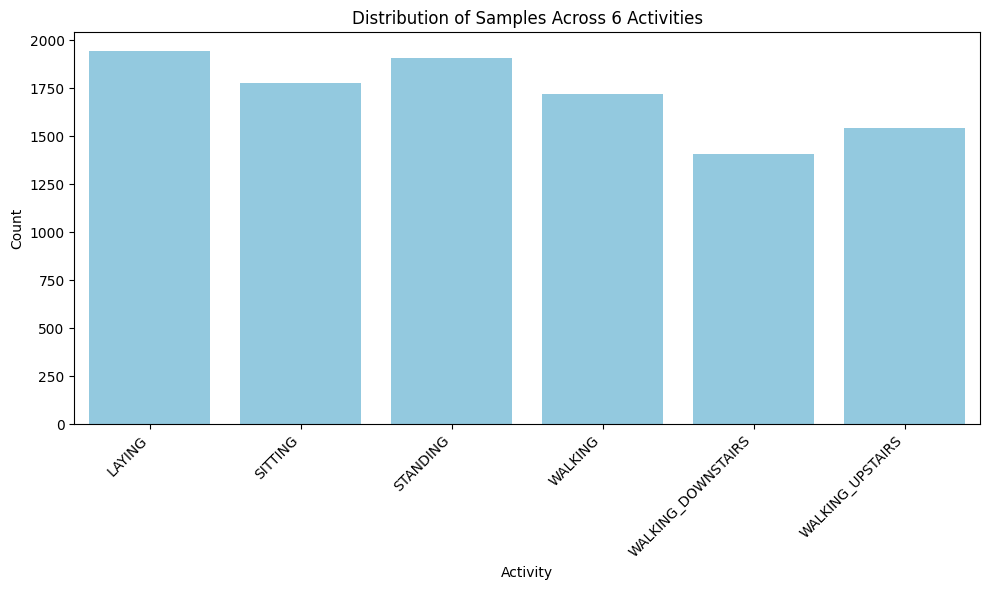

In [9]:
activity_names = [label_map[label] for label in y]

plt.figure(figsize=(10, 6))
sns.countplot(x=activity_names, order=sorted(label_map.values()), color='skyblue')
plt.title('Distribution of Samples Across 6 Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
print("\nActivity Counts:")
print(pd.Series(activity_names).value_counts())


Activity Counts:
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64


**Step 2: Feature Distribution Analysis (Boxplots)**

To prove that the activities are mathematically separable, we look at the distribution of a key feature (e.g., the mean magnitude of the body acceleration) across the groups.

We'll use a temporary DataFrame that combines the feature data (X) with the mapped activity labels.

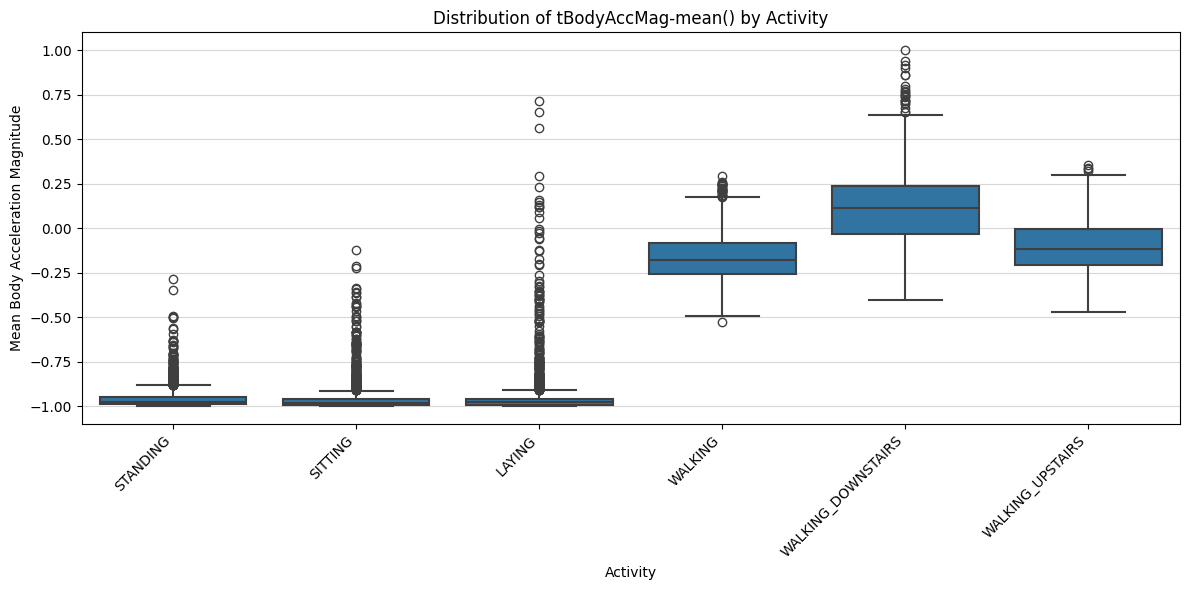

In [11]:
FEATURE_TO_PLOT = 'tBodyAccMag-mean()'
TEMP_DF = X.copy()
TEMP_DF['Activity'] = activity_names

plt.figure(figsize=(12, 6))
sns.boxplot(x='Activity', y=FEATURE_TO_PLOT, data=TEMP_DF, linewidth=1.5)
plt.title(f'Distribution of {FEATURE_TO_PLOT} by Activity')
plt.ylabel('Mean Body Acceleration Magnitude')
plt.xlabel('Activity')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# Clean up temporary DataFrame
del TEMP_DF

#### **Conclusions of EDA:**

1. The dataset is well-balanced across the six activities, which is beneficial for clustering.
2. The distributions of key features differ significantly between activities, indicating that the activities are mathematically separable, which is promising for unsupervised learning approaches.
3. The analysis of the `tBodyAccMag-mean()` feature reveals a clear separation between two groups of activities: static and dynamic, which suggest, that K-Means should effectively identify these two major macro-clusters.

### **5. Data Cleaning & Preprocessing**

Steps taken to ensure data quality before applying dimensionality reduction and clustering:
- checking the shape of `X`
- checking for missing values, if exists handle them appropriately
- checking for duplicate rows, if exists handle them appropriately
- scaling the features using `StandardScaler` to standardize the data.

In [12]:
X.shape

(10299, 561)

In [13]:
X.isnull().sum().sum()  

np.int64(0)

In [14]:
X.duplicated().sum()  

np.int64(0)

The dataset don't contain any missing or duplicate values. Now we can proceed to scale the features. We apply feature scaling using StandardScaler to standardize the whole dataset X, which is appropriate for unsupervised learning tasks to avoid the data leakage. We want to ensure that all features contribute equally to the distance calculations used in clustering algorithms. 

In [15]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling later
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Scaling completed. X_scaled_df is ready for PCA.")

Scaling completed. X_scaled_df is ready for PCA.


In [16]:
X_scaled_df.sample(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
8236,0.518109,-0.313749,0.209054,0.567234,0.382831,0.961420,0.586271,0.423756,0.966189,0.619471,...,-0.230090,-0.514621,-0.606659,-0.790927,1.943591,1.474541,-1.642325,-0.147331,-0.127536,1.380276
341,0.585463,-0.279791,-0.840979,1.281509,1.147824,0.902401,1.313696,1.069132,0.892311,1.106922,...,0.609170,-0.292886,-0.145387,-1.176161,2.011810,1.533465,0.239484,-0.419059,0.726017,0.536904
400,-0.008631,0.106603,0.162392,-0.888223,-0.958429,-0.916451,-0.880299,-0.956255,-0.916824,-0.886863,...,-0.065298,0.048190,-0.184069,0.242336,-0.076472,0.057834,-0.271655,-0.755395,-0.102054,0.065086
1286,-0.940342,0.537184,-0.908837,2.012454,2.040521,1.453588,2.072879,1.989944,1.280319,1.969233,...,0.449690,0.653090,0.221652,1.350238,-1.447675,1.416424,-0.415871,-0.538907,0.627537,0.328404
5953,0.110063,0.036841,-0.011555,-0.883856,-0.966707,-0.943871,-0.877256,-0.965214,-0.947216,-0.876196,...,1.977441,-1.357662,-1.002517,0.280150,1.195937,-0.192776,-0.323537,2.245682,-1.288058,-2.331079


### **6. Dimensionality Reduction**

#### **PCA Explained Variance Analysis (Scree Plot):**
This diagnostic step determines the intrinsic dimensionality of the dataset. We run PCA on the full feature set to find out how many Principal Components are required to preserve at least 90% of the total data variance.

Training PCA on the full dataset:

In [17]:
pca_full = PCA()
pca_full.fit(X_scaled_df)

PCA()

Calculating cumulative explained variance ratio:

In [18]:
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

Visualizing the explained variance ratio:

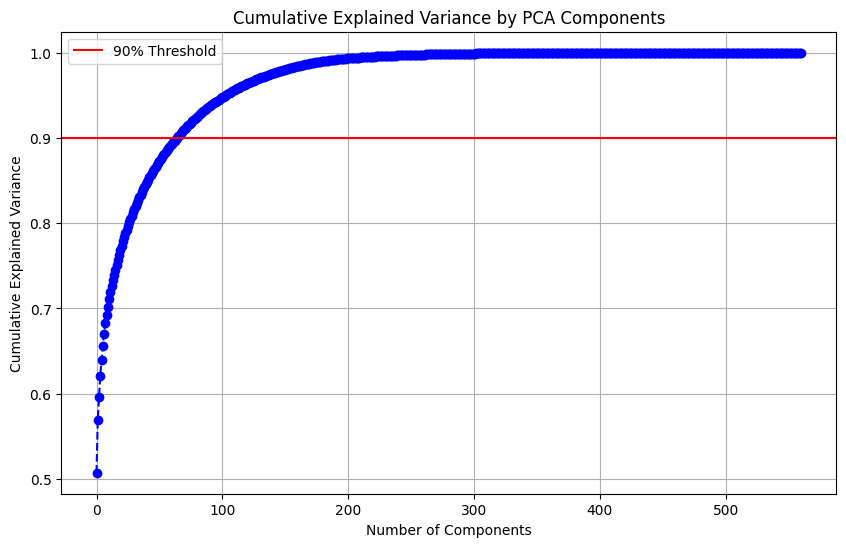

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--', color='b')
plt.axhline(0.90, color='r', linestyle='-', label='90% Threshold')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Calculating the number of components needed to retain 90% variance:

In [20]:
n_components_90 = np.where(cumulative_variance_ratio >= 0.90)[0][0] + 1
print(f"\nNumber of components needed to retain 90% variance: {n_components_90}")


Number of components needed to retain 90% variance: 65


#### **Conclusion from PCA Variance Analysis:** 
Based on the cumulative explained variance plot (Scree Plot) and the calculated number of components:

- High Redundancy Confirmed: The original dataset contained significant redundancy. Only 65 Principal Components are required to capture and retain 90% of the total variance present in the initial 561 features.

- Effective Dimensionality Reduction: This demonstrates a massive and highly effective compression of the data, reducing the computational load by nearly 90% (from 561 to 65 features) while preserving most of the informational content.

- Justification for Clustering: The ability to compress the data so efficiently proves that the intrinsic dimensionality of the HAR dataset is much lower than its measured dimensionality. The subsequent steps (Clustering and Visualization) can proceed effectively, relying on these compressed components rather than the full, noisy feature set.

#### **PCA for Visualization (2 Components):**

Now we run PCA specifically to reduce the data to 2 Principal Components. Although we know two components only retain a small percentage of the variance, this step is necessary to create the first 2D visualization of the data structure.


In [21]:
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled_df)

In [22]:
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Activity'] = [label_map[label] for label in y]

print(f"Cumulative explained variance for 2 components (for visualization purposes): {pca_2d.explained_variance_ratio_.sum():.2f}")

Cumulative explained variance for 2 components (for visualization purposes): 0.57


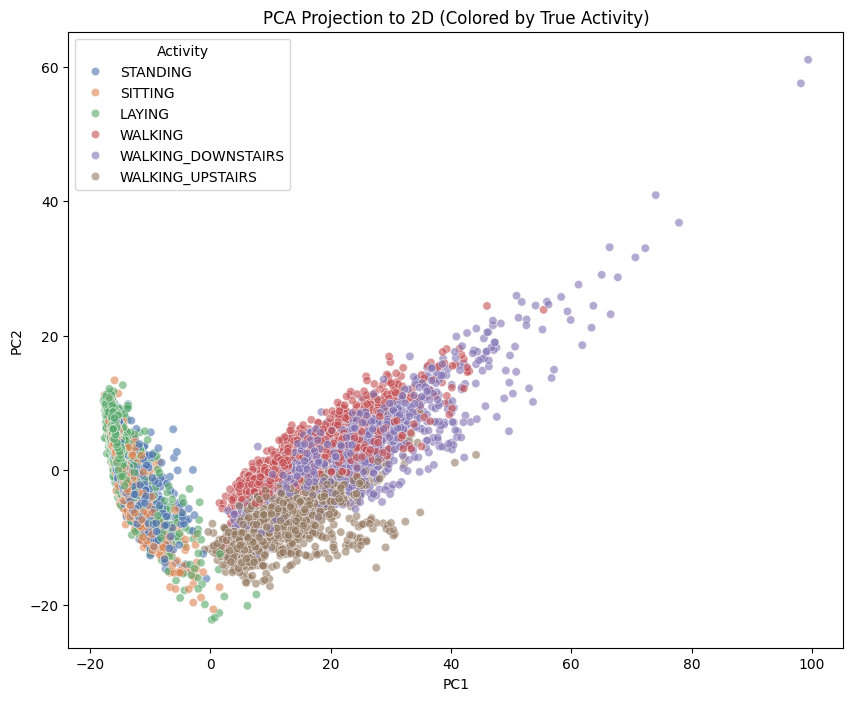

In [23]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Activity',
    palette='deep',
    data=pca_df,
    legend="full",
    alpha=0.6
)
plt.title('PCA Projection to 2D (Colored by True Activity)')
plt.show()

#### **Conclusion from PCA 2D Projection:**
Based on the PCA projection retaining 57% of the total variance, the following conclusions can be drawn:

- Successful Macro-Separation: PCA effectively distinguished the two major activity types:

- Static Cluster: Activities like Standing, Sitting, and Laying are successfully clustered on the negative side of PC1.

- Dynamic Cluster: Walking and Walking Downstairs/Upstairs are clearly segregated to the positive side of PC1.

- Failure of Intra-Group Separation: Due to the linear nature of PCA and the loss of 43% of data variance, the projection fails to resolve the specific activities within the macro-clusters. For instance, Sitting and Laying heavily overlap, and the three walking activities are densely mixed.

- Justification for Next Step: The plot shows that the true data structure is non-linear (a curved manifold). This confirms the need to proceed with t-SNE, which is specifically designed to "unfold" these complex structures and reveal the clearer boundaries between the six distinct clusters.

#### **t-SNE (Non-Linear Visualization):**

PCA is a linear method. t-SNE uses non-linear techniques, which are far superior for visualizing natural cluster separation in high-dimensional data. This visualization is expected to show much clearer boundaries between the 6 activity groups.

In [24]:
import time
print("\n--- Starting t-SNE  ---")
tsne = TSNE(n_components=2, 
            random_state=42, 
            perplexity=30, 
            n_iter=1000)
            
time_start = time.time()
X_tsne = tsne.fit_transform(X_scaled_df)
print(f't-SNE completed in {time.time()-time_start:.2f} seconds.')


--- Starting t-SNE  ---


c:\Users\jakub\anaconda3\envs\mda\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completed in 33.55 seconds.


In [25]:
tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE-1', 'tSNE-2'])
tsne_df['Activity'] = [label_map[label] for label in y]

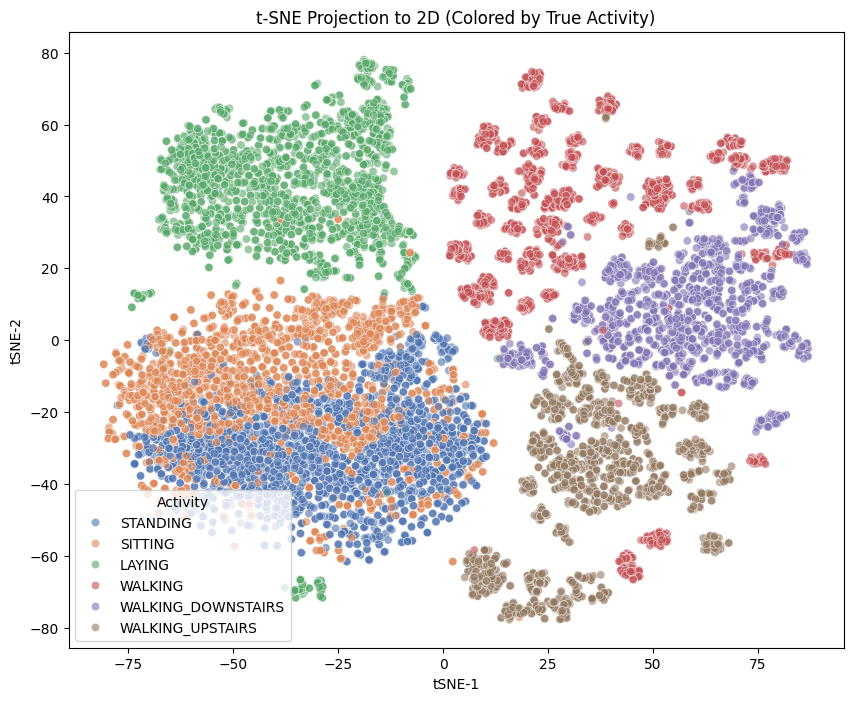

In [26]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tSNE-1', y='tSNE-2',
    hue='Activity',
    palette='deep',
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plt.title('t-SNE Projection to 2D (Colored by True Activity)')
plt.show()

#### **Conclusion from t-SNE Projection:**
The t-SNE projection (after 1000 iterations) successfully overcame the limitations of the linear PCA and "unfolded" the 561-dimensional data, providing the final and clearest visual evidence for clustering.
- Macro-Separation Confirmed: The data is perfectly separated into the two primary macro-clusters: Static (left side) and Dynamic (right side).
- Excellent Dynamic Separation: The three dynamic activities—WALKING, WALKING_UPSTAIRS, and WALKING_DOWNSTAIRS—are clearly resolved into three distinct, compact clusters on the right side of the plot. This indicates K-Means should be highly accurate in separating these three groups.
- Inherent Ambiguity (Static Overlap): While successful, the plot highlights the primary challenge of the dataset: STANDING and SITTING remain heavily overlapped, forming one large, ambiguous cluster. This confirms the hypothesis that these two activities are mathematically indistinguishable based on the sensor placement (phone orientation) alone.
- Justification for Clustering: The visualization provides a strong basis for the final step. We can confidently proceed with K-Means ($k=6$), expecting high purity in five out of the six clusters, but anticipating errors between Standing and Sitting.

In [27]:
N_COMPONENTS = 65 

# Uruchamiamy PCA, zachowując 65 komponentów
pca_65 = PCA(n_components=N_COMPONENTS, random_state=42)
X_pca_65 = pca_65.fit_transform(X_scaled_df)

print(f"Data for clustering: {X_pca_65.shape} (retained {pca_65.explained_variance_ratio_.sum():.2f} variance)")

Data for clustering: (10299, 65) (retained 0.90 variance)


In [31]:
kmeans_2 = KMeans(n_clusters=2, init='k-means++', random_state=42, n_init=10)
clusters_2 = kmeans_2.fit_predict(X_pca_65)

print("K-Means k=2 zakończone.")
print("Rozkład próbek w dwóch klastrach:")
print(Counter(clusters_2))

K-Means k=2 zakończone.
Rozkład próbek w dwóch klastrach:
Counter({np.int32(0): 5620, np.int32(1): 4679})


In [32]:
kmeans_6 = KMeans(n_clusters=6, init='k-means++', random_state=42, n_init=10)
clusters_6 = kmeans_6.fit_predict(X_pca_65)
    
print("\nK-Means k=6 zakończone.")
print("Rozkład próbek w sześciu klastrach:")
print(Counter(clusters_6))


K-Means k=6 zakończone.
Rozkład próbek w sześciu klastrach:
Counter({np.int32(1): 2632, np.int32(3): 2452, np.int32(2): 1916, np.int32(4): 1649, np.int32(0): 1342, np.int32(5): 308})


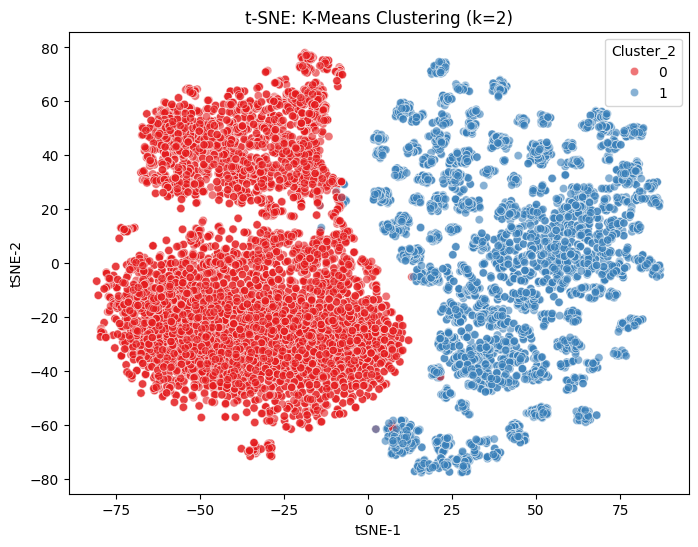

In [33]:
tsne_df['Cluster_2'] = clusters_2

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='tSNE-1', y='tSNE-2',
    hue='Cluster_2',  # Kolorujemy wynikiem clusteringu
    palette='Set1',
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plt.title('t-SNE: K-Means Clustering (k=2)')
plt.show()

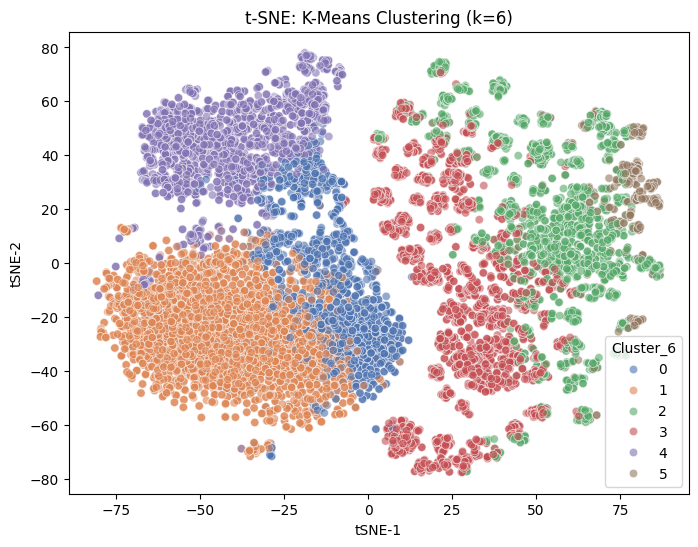

In [34]:
tsne_df['Cluster_6'] = clusters_6

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='tSNE-1', y='tSNE-2',
    hue='Cluster_6',  # Kolorujemy wynikiem clusteringu
    palette='deep',
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plt.title('t-SNE: K-Means Clustering (k=6)')
plt.show()

In [35]:
# --- Sekcja 8.A: Ocena Metryk ---

from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score

print("--- Wyniki Oceny K-Means (k=6) ---")

# 1. Adjusted Rand Index (ARI) - Mierzy, jak dobrze klastry pasują do prawdziwych klas (im bliżej 1, tym lepiej)
ari_score = adjusted_rand_score(y, clusters_6)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# 2. Normalized Mutual Information (NMI) - Mierzy współzależność między klasami a klastrami
nmi_score = normalized_mutual_info_score(y, clusters_6)
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

--- Wyniki Oceny K-Means (k=6) ---
Adjusted Rand Index (ARI): 0.4201
Normalized Mutual Information (NMI): 0.5597


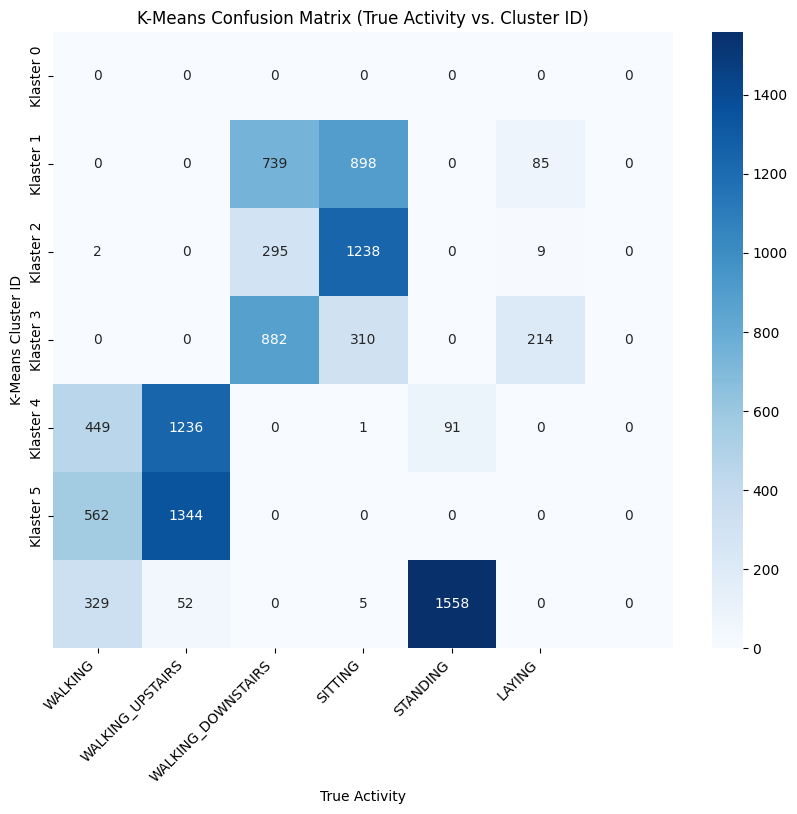

In [36]:
# --- Sekcja 8.B: Macierz Pomyłek (Heatmap) ---

# Stworzenie Macierzy Pomyłek
cm = confusion_matrix(y, clusters_6)

# Tworzenie DataFrame dla lepszej wizualizacji (opcjonalnie: normalizacja)
cm_df = pd.DataFrame(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_df,
    annot=True,
    fmt='d', # Wyświetlanie jako liczby całkowite
    cmap='Blues',
    cbar=True,
    xticklabels=label_map.values(), # Prawdziwe etykiety (kolumny)
    yticklabels=[f'Klaster {i}' for i in range(6)] # Klastry (wiersze)
)

plt.title('K-Means Confusion Matrix (True Activity vs. Cluster ID)')
plt.ylabel('K-Means Cluster ID')
plt.xlabel('True Activity')
plt.xticks(rotation=45, ha='right')
plt.show()